<a href="https://colab.research.google.com/github/Follisim/motion_blur/blob/main/motion_blur.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Motion_blur
Simone Folli \
matricola : 0000974629

In [ ]:
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.datasets import mnist

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

## generatore

In [ ]:
def generator(dataset,batchsize,moves=10):
  while True:
    rand = np.random.randint(dataset.shape[0],size=batchsize)
    y_truth = dataset[rand]
    blurred = np.copy(y_truth)
    moving = tf.expand_dims(y_truth,axis=-1)

    for i in range(moves):
      #RandomTranslation requires a channel axis
      moving = layers.RandomTranslation(0.07,0.07,fill_mode='constant',interpolation='bilinear')(moving)
      blurred = blurred + tf.squeeze(moving)
    blurred = blurred/(moves+1)
    yield(blurred,y_truth)


## stampa

In [ ]:
def plot(x,y):
  no = x.shape[0]
  print(no)
  plt.figure(figsize=(2*no, 4))
  for i in range(no):
    # display original
    ax = plt.subplot(2, no, i + 1)
    plt.imshow(x[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, no, i + 1 + no)
    plt.imshow(y[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
  plt.show()

## dataset

In [ ]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = (x_train/255.).astype(np.float32) # 60000 immagini per il trainig
x_test = (x_test/255.).astype(np.float32) # 10000 immagini per la validazione


##  autoencoder
una buona soluzione per data denoising, sono gli autoencoders\
costruiamo un autoencoder in keras convoluzionale con l'agiunta di skip connections\
le connesioni skip permettono di combinare le caratteristiche apprese dallo strato di contrazione (encoder) con quelle dello strato di espansione (decoder). migliorando la precisione della ricostruzione dell'immagine, in piu Riduzione dell'Effetto di Vanishing Gradient


In [ ]:
import keras
from keras import layers
from tensorflow.keras.optimizers import Adam

input_img = keras.Input(shape=(28, 28, 1))


#encoder
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(input_img)
x1 = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2))(x1)
x2 = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(x)
x = layers.MaxPooling2D((2, 2))(x2)


x = layers.Conv2D(254, (3, 3), activation='relu', padding='same')(x)

# dimensione a questo punto: ( 7, 7)

#decoder
x = layers.UpSampling2D((2, 2))(x)
con = layers.Concatenate()([x,x2])
x = layers.Conv2D(128, (3, 3), activation='relu', padding='same')(con)
x = layers.UpSampling2D((2, 2))(x)
con = layers.Concatenate()([x,x1])
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(con)
x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
decoded = layers.Conv2D(1,(1,1),activation='relu')(x)



In [ ]:
autoencoder = Model(input_img, decoded)
adam = Adam(learning_rate = 0.001)
autoencoder.compile(optimizer= adam ,metrics = ["accuracy"], loss='mean_squared_error')

autoencoder.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 28, 28, 1)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 28, 28, 64)           640       ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 28, 28, 64)           36928     ['conv2d[0][0]']              
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 14, 14, 64)           0         ['conv2d_1[0][0]']            
 D)                                                                                           

## immagini per il training

In [ ]:
my_train = generator(x_train,150000)
train_x,train_y = next(my_train)

## training
Quindi addestriamo il nostro modello.\
Nell'elenco delle callback passiamo un'istanza della callback TensorBoard. Dopo ogni epoca, questa callback scriverà i log su /tmp/autoencoder


In [ ]:
from keras.callbacks import TensorBoard

autoencoder.fit(train_x, train_y,
                epochs=12,
                batch_size=100,
                shuffle=True,
                validation_data=(train_x, train_y),
                callbacks=[TensorBoard(log_dir='/tmp/autoencoder')])



Epoch 1/12
1500/1500 [==============================] - 90s 52ms/step - loss: 0.0184 - accuracy: 0.8081 - val_loss: 0.0091 - val_accuracy: 0.8114
Epoch 2/12
1500/1500 [==============================] - 76s 51ms/step - loss: 0.0071 - accuracy: 0.8130 - val_loss: 0.0060 - val_accuracy: 0.8132
Epoch 3/12
1500/1500 [==============================] - 76s 51ms/step - loss: 0.0056 - accuracy: 0.8138 - val_loss: 0.0050 - val_accuracy: 0.8141
Epoch 4/12
1500/1500 [==============================] - 76s 51ms/step - loss: 0.0049 - accuracy: 0.8141 - val_loss: 0.0047 - val_accuracy: 0.8144
Epoch 5/12
1500/1500 [==============================] - 74s 49ms/step - loss: 0.0044 - accuracy: 0.8143 - val_loss: 0.0041 - val_accuracy: 0.8146
Epoch 6/12
1500/1500 [==============================] - 74s 49ms/step - loss: 0.0041 - accuracy: 0.8145 - val_loss: 0.0038 - val_accuracy: 0.8145
Epoch 7/12
1500/1500 [==============================] - 76s 51ms/step - loss: 0.0039 - accuracy: 0.8146 - val_loss: 0.0037 -

## valutazione
Usiamo Mean Squared Error (mse) per valutare l'errore tra 10000 immagini deblurred e le ground truth, ripetiamo 10 volte,\
stampiamo i risultati e mse medio



313/313 [==============================] - 2s 5ms/step


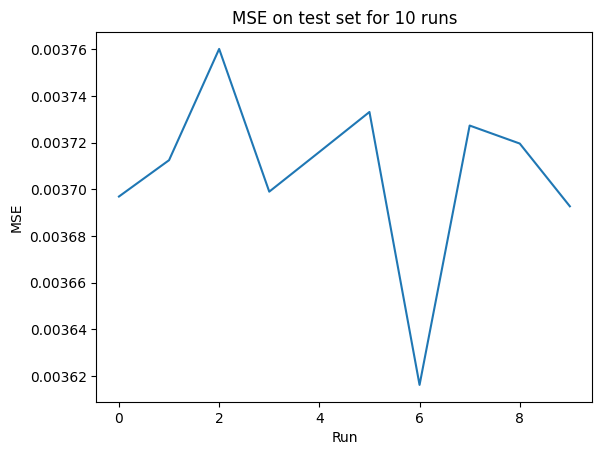

media mse: 0.003707314


In [ ]:
mse_calculator = tf.keras.losses.MeanSquaredError()
all_mse_scores = []

for run in range(10):
    test_x,test_y = next(generator(x_test,10000))
    pred_subset = autoencoder.predict(test_x)

    test_y = tf.expand_dims(test_y, axis=-1)
    mse_score = mse_calculator(test_y,pred_subset).numpy()
    all_mse_scores.append(mse_score)

runs = np.arange(0,10)
plt.plot(runs,all_mse_scores)
plt.xlabel('Run')
plt.ylabel('MSE')
plt.title('MSE on test set for 10 runs')
plt.show()

print("media mse:" , np.mean(all_mse_scores))

10


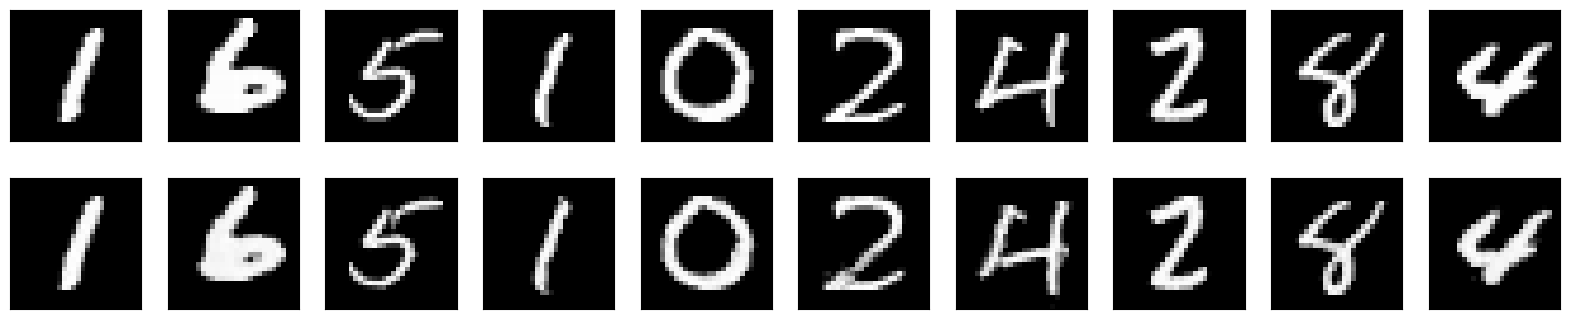

In [ ]:
plot(test_y[:10],pred_subset[:10])

10


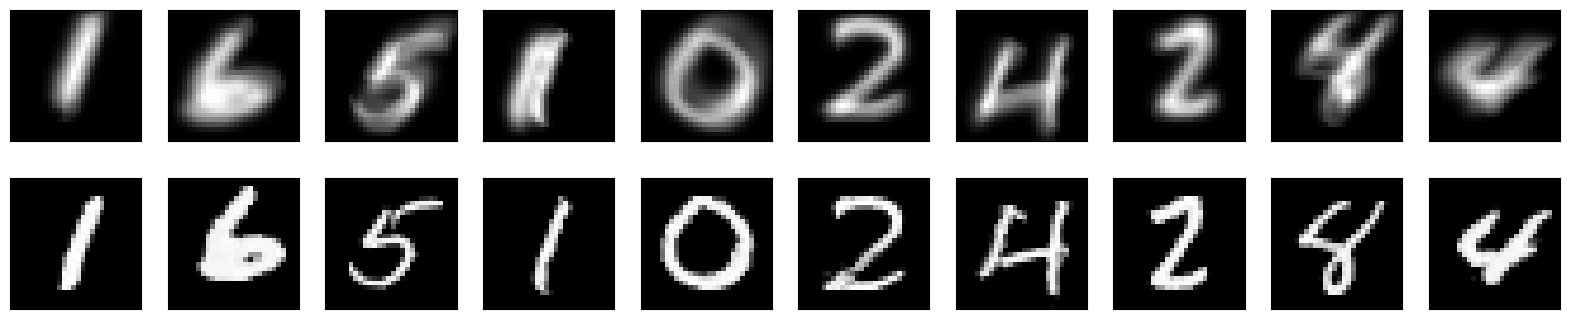

In [ ]:
plot(test_x[:10],pred_subset[:10])